In [1]:
from vqvae import VQVAE


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import functional as F

import numpy as np

# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm



c:\Users\kajou\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# 1. Load and Preprocess the Dataset
transform = transforms.Compose([
    transforms.ToTensor(),               # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,)) # Normalize the images to [-1, 1]
])

# Download and load the Fashion-MNIST training and test dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

TrainLoader = DataLoader(train_dataset, batch_size=32, shuffle=True)
TestLoader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class labels for reference
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



In [3]:
K =  512 # num_embeddings
D =  64 # embedding_dim
in_channels = 1
downsampling_factor = 2

In [4]:
VQVAE = VQVAE(in_channels, D, K, downsampling_factor)

In [5]:

# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


False
cpu


In [6]:

### Learning parameters

model = VQVAE.to(device)

lr = 1e-4
epochs = 10
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

model_name = 'model_101.pth'

In [7]:

# visualisation batch, to track the performance of the model
vis_batch, classes = next(iter(TestLoader))



In [8]:
# 6. Visualize a Few Test Images and Their Predictions
def visualize_predictions(images):

    # Plot the images and predicted labels
    fig = plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = fig.add_subplot(3, 3, i+1)
        ax.imshow(images[i].numpy().squeeze(), cmap='gray')
        ax.axis('off')
    
    plt.show()

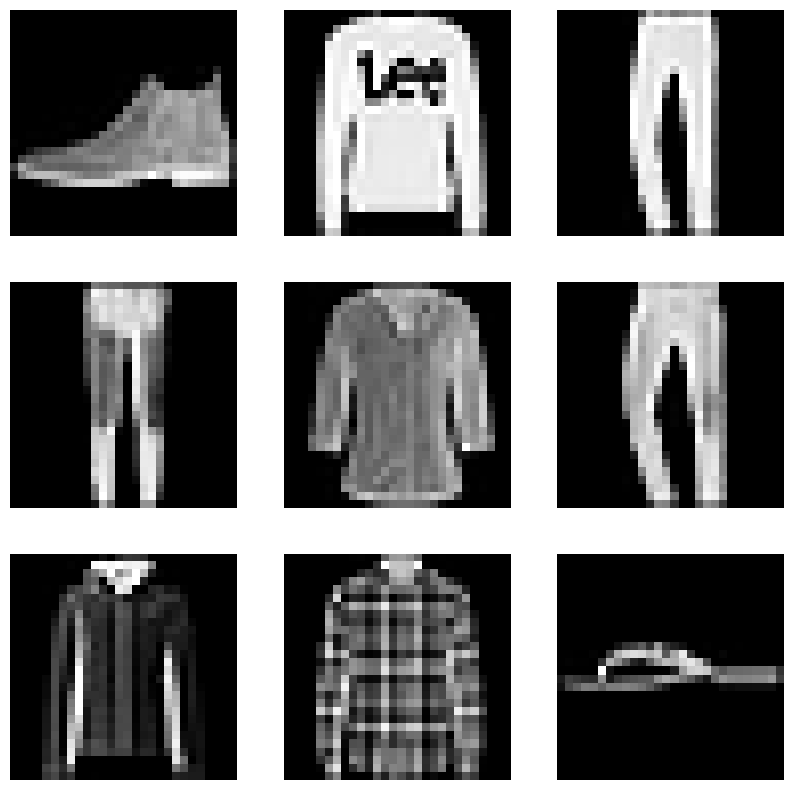

In [9]:
visualize_predictions(vis_batch)

In [10]:
def evaluate_model(model, val_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for (images, classes) in val_loader:
            inputs = images.float().to(device)
           
            outputs, _, _, _ = model(inputs)
            
            # Loss and backward
            loss = F.mse_loss(inputs, outputs)
            
            val_loss.append(loss.item() )

    avg_val_loss = np.mean(np.array(val_loss))

    return avg_val_loss


model.train()
train_loss_values = []
codebook_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs, classes) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, codebook_loss, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, codebook_loss, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += codebook_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader, device)
    val_loss_values.append(val_loss)

    # #track output precision progression every 10 epoch:
    # if (epoch%5 == 0 and epoch<50):
    #     output, _, _, _ = model( vis_batch.float() )
    #     recons_evolution.append(output)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")


100%|██████████| 1875/1875 [01:50<00:00, 16.94batch/s, loss=0.679]


Epoch 0: Train Loss: 0.6882


100%|██████████| 1875/1875 [01:54<00:00, 16.38batch/s, loss=0.674]


Epoch 1: Train Loss: 0.6816


100%|██████████| 1875/1875 [01:56<00:00, 16.15batch/s, loss=0.67] 


Epoch 2: Train Loss: 0.6816


100%|██████████| 1875/1875 [01:55<00:00, 16.19batch/s, loss=0.655]


Epoch 3: Train Loss: 0.6816


100%|██████████| 1875/1875 [01:58<00:00, 15.84batch/s, loss=0.687]


Epoch 4: Train Loss: 0.6816


100%|██████████| 1875/1875 [01:54<00:00, 16.31batch/s, loss=0.689]


Epoch 5: Train Loss: 0.6816


100%|██████████| 1875/1875 [01:54<00:00, 16.39batch/s, loss=0.69] 


Epoch 6: Train Loss: 0.6816


100%|██████████| 1875/1875 [01:54<00:00, 16.32batch/s, loss=0.659]


Epoch 7: Train Loss: 0.6816


100%|██████████| 1875/1875 [01:59<00:00, 15.71batch/s, loss=0.715]


Epoch 8: Train Loss: 0.6816


100%|██████████| 1875/1875 [01:32<00:00, 20.33batch/s, loss=0.742]


Epoch 9: Train Loss: 0.6816
Training complete.


In [12]:
def plot_train_val_loss(train_loss_values, val_loss_values ):
    # Plot the training and validation losses
    plt.figure(figsize=(20, 10))
    plt.plot(train_loss_values, label='Train Loss')
    plt.plot(val_loss_values, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Evolution of Loss')
    plt.legend()
    plt.grid()
    plt.show()


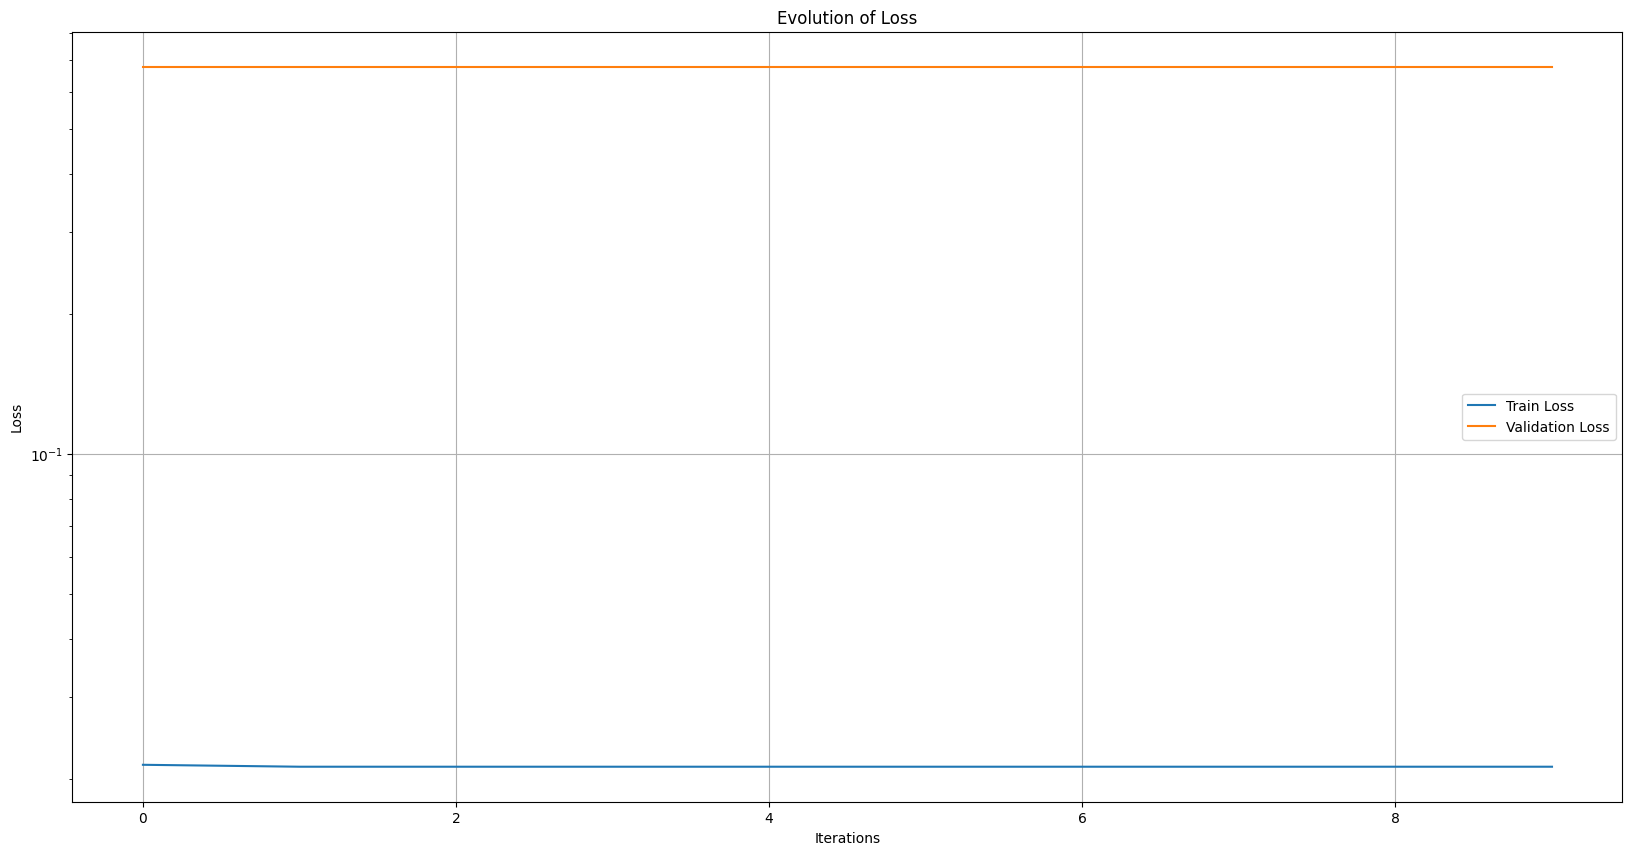

In [13]:
plot_train_val_loss(train_loss_values, val_loss_values)

In [31]:
def visualize_errors(true_seg, pred_seg, title):
    # batch_size = batch.shape[0]
    samples = 8

    fig, axes = plt.subplots(samples, 2, figsize=(10, 20))  # Adjust figsize to accommodate more rows
    fig.suptitle(title, fontsize=16)


    for i in range(samples):
        axes[i,0].imshow(true_seg[i].squeeze(), cmap = 'gray')
        axes[i,0].axis('off')

        axes[i,1].imshow(pred_seg[i].squeeze(),cmap = 'gray')
        axes[i,1].axis('off')


    row_titles = ['Ground truth', 'Vq-Vae predictions']
    for i in range(2):
        axes[0, i].set_title(row_titles[i], fontsize=14, fontweight='bold')
    
    # plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

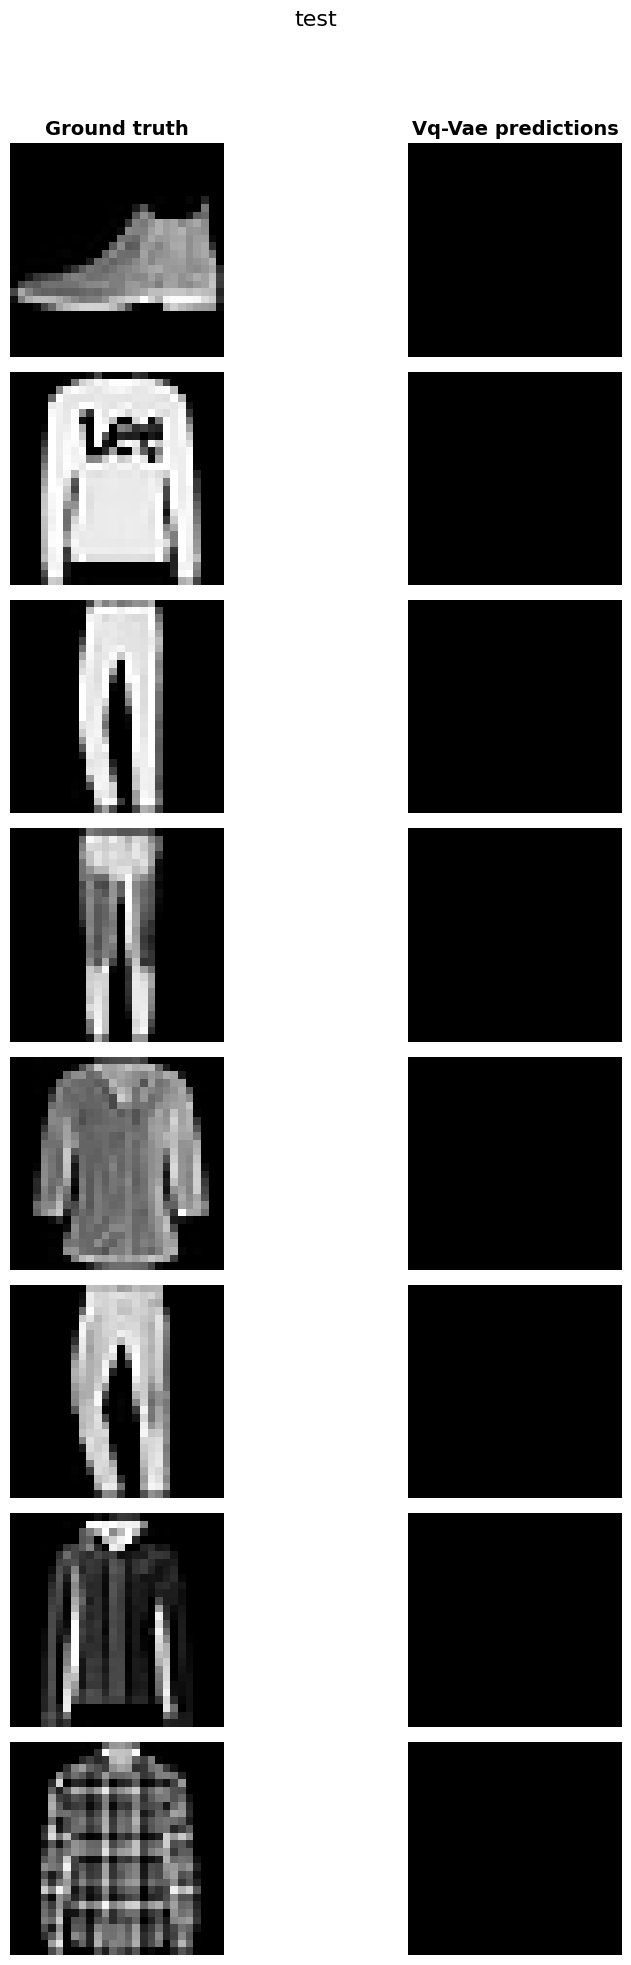

In [38]:
vis_batch.detach().cpu()
batch_hat,_,_,_ = model(vis_batch)
batch_hat = batch_hat.detach().cpu()

visualize_errors(vis_batch, batch_hat, 'test')